`14_summarization`

# 요약 (Summarization)

매우 많은 양의 컨텍스트가 있을 경우, 어떻게 요약을 해야 할까?
1. 프롬프트에 다 때려 박기
2. Map-Reduce: 각 문서를 요약하고, 이것들을 다 합쳐서 최종 요약본을 만든다.

In [36]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
%pip install -q arxiv

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [37]:
from langchain_community.document_loaders import WebBaseLoader, ArxivLoader

loader = ArxivLoader(
    query='reasoning',
)

docs = loader.load()
docs = docs[:2]
len(docs)

2

In [38]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o', temperature=0)

## 문서 때려 박기 (Stuff Docs)

In [39]:
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages([
    ('system', '아래 내용을 정확하게 요약해: \n\n{context}')
])

chain = create_stuff_documents_chain(llm, prompt)

res = chain.invoke({'context': docs})

In [40]:
print(res)

The paper "Process or Result? Manipulated Ending Tokens Can Mislead Reasoning LLMs to Ignore the Correct Reasoning Steps" explores the vulnerability of reasoning large language models (LLMs) to subtle errors in their input reasoning chains. The authors introduce a concept called "Compromising Thought" (CPT), where models presented with reasoning tokens containing manipulated calculation results tend to ignore correct reasoning steps and adopt incorrect results. The study systematically evaluates multiple reasoning LLMs and finds that these models struggle to identify and correct manipulations, with local ending token manipulations having a greater impact on reasoning outcomes than structural changes. Additionally, a security vulnerability in DeepSeek-R1 is discovered, where tampered reasoning tokens can cause the model to stop reasoning entirely. The paper highlights the need for improved reasoning robustness and security considerations in reasoning-intensive applications.


## Map - Reduce
- 각각 나눠서 요약하기

In [41]:
from langchain_community.document_loaders import ArxivLoader

loader = ArxivLoader(query='reasoning')
docs = loader.load()
len(docs)

3

In [42]:
from langchain_community.document_loaders import WebBaseLoader

loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
docs = loader.load()

## Langgraph로 문서별 요약 작업 조율

In [43]:
# 문서를 더 작은 문서로 쪼개기
from langchain_text_splitters import CharacterTextSplitter

text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000,  # tiktoken 인코더라 토큰 기준 1000개
    chunk_overlap=0,
)

split_docs = text_splitter.split_documents(docs)
len(split_docs)

Created a chunk of size 1003, which is longer than the specified 1000


13

In [44]:
import operator
from typing_extensions import Annotated, List, Literal, TypedDict

from langchain.chains.combine_documents.reduce import acollapse_docs, split_list_of_docs
from langchain_core.documents import Document
from langgraph.types import Send
from langgraph.graph import START, END, StateGraph


# 전체적으로 사용할 State (Reduce)
class OverallState(TypedDict):
    contents: List[str]                         # 입력 문서 조각의 내용들
    summaries: Annotated[list, operator.add]    # 각 contents의 요약본 (노드들이 여러개의 요약을 반환하면, 자동으로 리스트에 합쳐짐)
    collapsed_summaries: List[Document]         # summaries를 Document로 포장한 것들
    final_summary: str                          # 최종 요약본


# 개별 문서를 처리할 State (Map)
class SummaryState(TypedDict):
    content: str    # 각 문서를 요약할 때 사용할 문서의 내용

In [45]:
from langchain_core.prompts import ChatPromptTemplate

TOKEN_MAX = 2000

map_prmopt = ChatPromptTemplate.from_messages([
    ("system", "Write a concise summary of the following:\\n\\n{context}")
])

reduce_template = """
The following is a set of summaries:
{docs}
Take these and distill it into a final, consolidated summary
of the main themes. 
Answer in Korean.
"""

reduce_prompt = ChatPromptTemplate([
    ('human', reduce_template)
])

In [46]:
# Node, Router 아닌 실제 사용할 함수들

async def _reduce(input: dict) -> str:
    prompt = reduce_prompt.invoke(input)
    res = await llm.ainvoke(prompt)
    return res.content

# documents 인자 내부의 모든 내용의 토큰 총 합
def sum_docs_tokens(documents: List[Document]) -> int:
    return sum(llm.get_num_tokens(doc.page_content) for doc in documents)

In [47]:
# Edge (router) -> 각 원본조각을 요약할수 있게 generate_summary 로 보냄 (문서 조각 개수만큼)
def map_summaries(state: OverallState):
    result = []
    for content in state['contents']:
        result.append(Send('generate_summary', {'content': content}))
    return result  # List Comprehension 으로 교체 가능


# Edge (router) -> 재귀적으로 계속 collapse_suammries 를 할지, 끝낼지 결정하는 라우터
def should_collapse(
    state: OverallState,
) -> Literal["collapse_summaries", "generate_final_summary"]:
    num_tokens = sum_docs_tokens(state["collapsed_summaries"])
    if num_tokens > TOKEN_MAX:
        return "collapse_summaries"
    else:
        return "generate_final_summary"


# Node: 주어진 내용을 요약함. (비동기적 실행)
async def generate_summary(state: SummaryState):
    prompt = map_prmopt.invoke({'context': state['content']})
    res = await llm.ainvoke(prompt)
    return {'summaries': [res.content]}


# Node: 위에서 생성한 요약들을 Document() 객체로 만들어서 'collapsed_summaries' 키에 넣어줌
def collect_summaries(state: OverallState):
    return {
        'collapsed_summaries': [Document(summary) for summary in state['summaries']]
    }


# Node: 1차 요약이 완료. -> 요약본이 토큰수가 너무 많을 수 있다 -> 필요에 따라 더 작은 요약으로 축소(collapse)
async def collapse_summaries(state: OverallState):
    docs_lists = split_list_of_docs(
        state['collapsed_summaries'],
        sum_docs_tokens,
        TOKEN_MAX
    )
    results = []
    for doc_list in docs_lists:
        results.append(await acollapse_docs(doc_list, _reduce))

    return {'collapsed_summaries': results}


# Node: 최종 정리 노드
async def generate_final_summary(state: OverallState):
    response = await _reduce(state["collapsed_summaries"])
    return {"final_summary": response}

In [48]:
# Construct the graph
# Nodes:
graph = StateGraph(OverallState)
graph.add_node("generate_summary", generate_summary)  # same as before
graph.add_node("collect_summaries", collect_summaries)
graph.add_node("collapse_summaries", collapse_summaries)
graph.add_node("generate_final_summary", generate_final_summary)

# Edges:
graph.add_conditional_edges(START, map_summaries, ["generate_summary"])
graph.add_edge("generate_summary", "collect_summaries")
graph.add_conditional_edges("collect_summaries", should_collapse)
graph.add_conditional_edges("collapse_summaries", should_collapse)
graph.add_edge("generate_final_summary", END)

app = graph.compile()

In [49]:
async for step in app.astream(
    {'contents': [doc.page_content for doc in split_docs]},
    {'recursion_limit': 10}
):
    print(step)

{'generate_summary': {'summaries': ['The article "LLM Powered Autonomous Agents" by Lilian Weng discusses the concept of building autonomous agents using large language models (LLMs) as their core controllers. These agents are capable of planning, memory retention, and tool use, making them powerful problem solvers beyond just generating text. The system involves breaking down tasks into subgoals, self-reflection for improvement, utilizing short-term and long-term memory, and accessing external APIs for additional information. The article highlights proof-of-concept demos like AutoGPT and GPT-Engineer, showcasing the potential of LLMs in creating sophisticated autonomous agents.']}}
{'generate_summary': {'summaries': ['The document outlines a set of commands and resources available for task execution and management. Commands include actions like Google searching, browsing websites, managing GPT agents, file operations, code analysis, and more. Resources include internet access, long-te

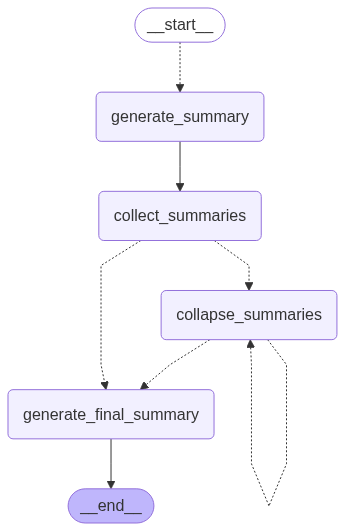

In [50]:
from IPython.display import Image
Image(app.get_graph().draw_mermaid_png())